XGBoost is basically a **gradient boosting algorithm** with some improvements, like the inclusion of a regularization parameter, and better performance.

Start by importing all the necessary libraries. In this case, we will make use of sklearn.metrics 
to obtain the ROC curve and area under the curve.

In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

signal = pd.read_pickle('10_signal.pkl')
bkgnd = pd.read_pickle('10_back.pkl') #sometimes we also use csv (comma separated value) files

#Useful columns or features
signal = signal[['Bpt' ,'kpt' ,'PDL' ,'prob' ,'cosA' ,'signLxy']]
bkgnd = bkgnd[['Bpt' ,'kpt' ,'PDL' ,'prob' ,'cosA' ,'signLxy']]

#Labels
bkgnd['signal/bkgnd'] = 0
signal['signal/bkgnd'] = 1

df = pd.concat([signal,bkgnd])

In [2]:
bkgnd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90908 entries, 86648 to 4408494
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bpt           90908 non-null  float32
 1   kpt           90908 non-null  float32
 2   PDL           90908 non-null  float32
 3   prob          90908 non-null  float32
 4   cosA          90908 non-null  float32
 5   signLxy       90908 non-null  float32
 6   signal/bkgnd  90908 non-null  int64  
dtypes: float32(6), int64(1)
memory usage: 3.5 MB


**Pre-processing**

train_x = all the useful columns minus the label

train_y = the true labels

In [3]:
#GENERAL DATA
train_x = df.drop(['signal/bkgnd'], axis=1) #features = all minus (signal/bkgnd and masses)
train_y = df['signal/bkgnd'] #label = signal/bkgnd

#SIGNAL
signal_x = signal.drop(['signal/bkgnd'], axis=1)
signal_y = signal['signal/bkgnd']

#BKGND
bkgnd_x = bkgnd.drop(['signal/bkgnd'], axis=1)
bkgnd_y = bkgnd['signal/bkgnd']

Split the data

Here, we spĺit the data in the following way:

    50 % training set
    50 % test set

In [4]:
#SIGNAL
train_signal_x, test_signal_x, train_signal_y, test_signal_y = train_test_split(signal_x, signal_y, 
                                                  test_size=0.5, 
                                                  random_state=1)
#BKGND
train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y = train_test_split(bkgnd_x, bkgnd_y, 
                                                  test_size=0.5, 
                                                  random_state=1)

In [5]:
test_x = test_signal_x.append(test_bkgnd_x)
test_y = test_signal_y.append(test_bkgnd_y)

train_x = train_signal_x.append(train_bkgnd_x)
train_y = train_signal_y.append(train_bkgnd_y)

**Define and train the model**

Here, you can adjust all the parameters of the model. We only use three of them, however there are tons
of parameters in the documentation.

Note that we are using the sklearn API for the XGB classifier. For that reason, we train the model by calling the fit function.

In [6]:
#XGBClassifier scikit-learn API 
model = xgb.XGBClassifier(objective = 'binary:logistic', 
                          max_depth=6, 
                          learning_rate=0.3,
                         reg_lambda=1000)
                         
#fit = training
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1000, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Accuracy of the model and predictions**

In [7]:
predict_signal = model.predict(test_x)
print(np.round(accuracy_score(test_y,predict_signal)*100, 2),'%')

97.57 %


In [8]:
#applying the model to test and training
predict_signal_test =  model.predict_proba(test_signal_x)[:,1]
predict_signal_train =  model.predict_proba(train_signal_x)[:,1]

predict_back_test = model.predict_proba(test_bkgnd_x)[:,1]
predict_back_train = model.predict_proba(train_bkgnd_x)[:,1]

**Overfitting crosscheck**

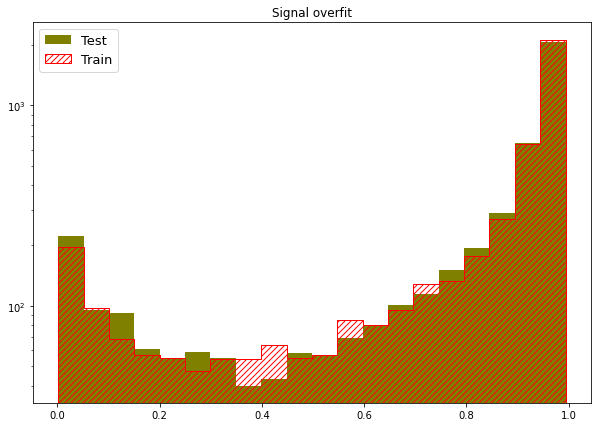

In [9]:
plt.figure(figsize=(10,7))
plt.title('Signal overfit')
m = plt.hist(predict_signal_test, bins=20, label='Test', color='olive')
plt.hist(predict_signal_train, bins=m[1], label='Train', 
         histtype='stepfilled', facecolor='none', edgecolor='red',
        hatch='////')
plt.legend(fontsize=13)
plt.yscale('log')
plt.show()

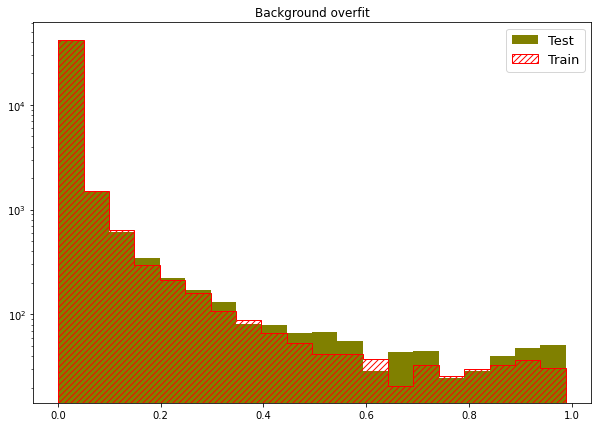

In [10]:
plt.figure(figsize=(10,7))
plt.title('Background overfit')
m = plt.hist(predict_back_test, bins=20, label='Test', color='olive',)
plt.hist(predict_back_train, bins=m[1], label='Train', 
         histtype='stepfilled', facecolor='none', edgecolor='red',
        hatch='////')
plt.legend(fontsize=13)
plt.yscale('log')
plt.show()

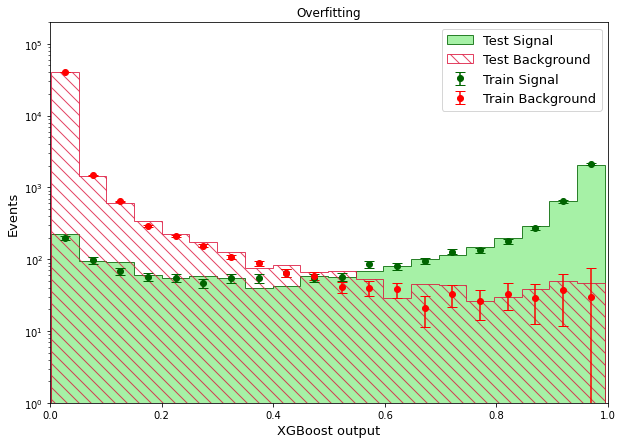

In [11]:
plt.figure(figsize=(10,7))
plt.title('Overfitting')
m = plt.hist(predict_signal_test, bins=20, label='Test Signal', facecolor='lightgreen', edgecolor="darkgreen",
             histtype='stepfilled', alpha=0.8)
train = np.histogram(predict_signal_train, bins=m[1])
bins_ = (train[1][1:]+train[1][:-1])/2
plt.errorbar(bins_, train[0],yerr=np.sqrt(train[0]), 
                 fmt='s', marker='o' ,color='darkgreen',
                barsabove=False, capsize=5, label='Train Signal')

plt.hist(predict_back_test, bins=m[1], label='Test Background',
             histtype='stepfilled', facecolor='none', edgecolor='crimson', hatch= '\\\\', alpha=0.8)
train2 = np.histogram(predict_back_train, bins=m[1])
bins_2 = (train2[1][1:]+train2[1][:-1])/2
plt.errorbar(bins_2, train2[0],yerr=np.sqrt(train[0]), 
                 fmt='s', marker='o' ,color='red',
                barsabove=False, capsize=5, label='Train Background')
plt.legend(fontsize=13)
plt.yscale('log')
plt.ylim(1, 200000)
plt.xlim(0, 1)
plt.ylabel('Events', fontsize=13)
plt.xlabel('XGBoost output', fontsize=13)
plt.show()

**The ROC curve**

ROC = receiver operating characteristic

Shows the performance of a classification model.

signal efficiency = true positive/(true positive + false negative)

background rejection = true negative/(true negative + false positive)

Test :  0.9827130651040755
Train :  0.9865008267887995


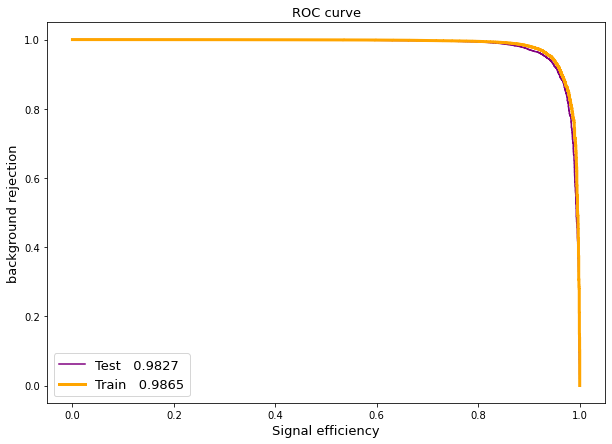

In [12]:
plt.figure(figsize=(10,7))
plt.title('ROC curve', fontsize=13)
model_predict = model.predict_proba(test_x)
model_predict = model_predict[:,1]
auc_score = roc_auc_score(test_y, model_predict) 
fpr, tpr, _ = roc_curve(test_y, model_predict) #roc_curve(true binary labels, prediction scores)
print('Test : ', auc_score)
plt.plot(tpr, 1-fpr, label='Test   '+ str(round(auc_score, 4)), color='purple')

model_predict = model.predict_proba(train_x)
model_predict = model_predict[:,1]
auc_score = roc_auc_score(train_y, model_predict)
fpr, tpr, _ = roc_curve(train_y, model_predict)
plt.plot(tpr, 1-fpr, label='Train   ' + str(round(auc_score,4)) , color='orange', linewidth=3)
print('Train : ', auc_score)
plt.legend(fontsize=13)
plt.ylabel('background rejection', fontsize=13)
plt.xlabel('Signal efficiency', fontsize=13)
plt.show()